### Custom Dataset Exploration for Pretrained PyTorch Models

This notebook demonstrates how to define and test a custom PyTorch Dataset and DataLoader
using a small subset of mammogram images. It includes preprocessing steps such as CLAHE,
random brightness/contrast, Gaussian noise, and normalisation, aligned with standard
requirements of pretrained models (e.g., ImageNet-based CNNs).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import random
import matplotlib.pyplot as plt

from PIL import Image
import os
import cv2
import pandas as pd
import numpy as np

In [ ]:
# Custom Dataset Definition
class CustomImageDataset(Dataset):
    """
    Custom Dataset to load mammogram images and labels from a CSV file.

    Args:
        annotations_file (str): Path to CSV file with image filenames and labels.
        img_dir (str): Directory containing the image files.
        transform (callable, optional): Transform to apply to each image.
        target_transform (callable, optional): Transform to apply to labels.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image_rgb = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 2]

        if self.transform:
            image_rgb = self.transform(image_rgb)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image_rgb, label

In [ ]:
# Custom Transformations
class AddGaussianNoise(torch.nn.Module):
    """
    Add Gaussian noise to a tensor with a given probability.
    """
    def __init__(self, mean=0.0, std=0.05, p=0.3):
        super().__init__()
        self.mean = mean
        self.std = std
        self.p = p

    def forward(self, tensor):
        # Apply noise with probability p
        if random.random() < self.p:  
            noise = torch.randn_like(tensor) * self.std
            # Keep values in [0,1]
            tensor = torch.clamp(tensor + noise, 0, 1)  
        return tensor
    
class ApplyCLAHE:
    """
    Apply Contrast Limited Adaptive Histogram Equalisation (CLAHE) to an image.
    """
    def __init__(self, clip_limit=5.0, tile_grid_size=(8,8), p=1.0):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        # Probability of applying CLAHE
        self.p = p  

    def __call__(self, img):
        # Apply CLAHE with probability p
        if random.random() < self.p:  
            img_np = np.array(img)  
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_clahe = clahe.apply(img_gray)

            img_clahe = cv2.merge([img_clahe, img_clahe, img_clahe])
            return Image.fromarray(img_clahe)
        return img


In [ ]:
# Define Transform Pipeline
train_transform  = T.Compose([
    T.Resize((224, 224)),
    #ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Apply CLAHE always
    T.ColorJitter(brightness=0.1, contrast=0.1),  # Random brightness & contrast
    T.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
    AddGaussianNoise(std=0.05, p=0.3),  # Apply Gaussian noise with 30% probability
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalise
])

In [ ]:
# Load Sample Data
calc_training_label_dir = "/Users/giulia/Desktop/dissertation-mammogram-classification/mammogram-ai-project/Data/Data png cropped/Calc-Training-png-cropped/labels/calc-train_labels.csv"
calc_training_img_dir = "/Users/giulia/Desktop/dissertation-mammogram-classification/mammogram-ai-project/Data/Data png cropped/Calc-Training-png-cropped/images"

train_data = CustomImageDataset(calc_training_label_dir, calc_training_img_dir, train_transform)

/var/folders/56/_z0lw68j7p14c6slvpgqxwgh0000gn/T/ipykernel_12914/1786418392.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(img)  # Convert to NumPy array
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3570516].


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5005665].


(3, 224, 224)
(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2565577].


(3, 224, 224)
(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.8447932].


(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].


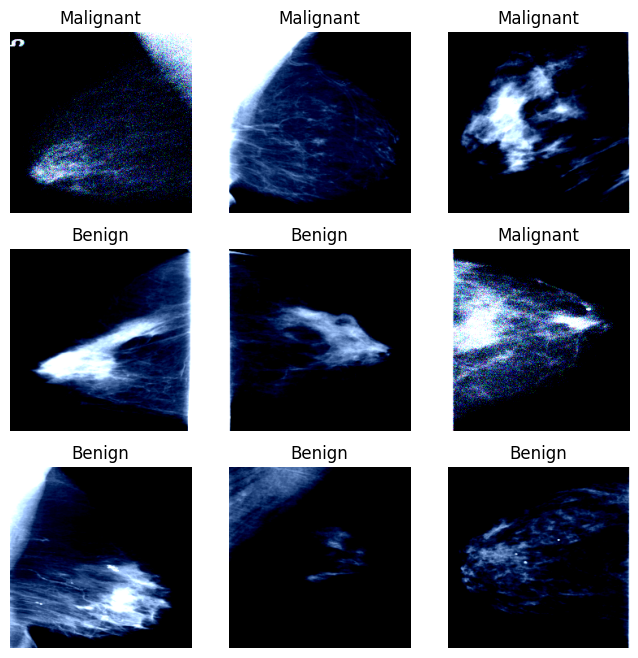

In [ ]:
# Visualise Random Samples
labels_map = {
    0: "Benign",
    1: "Malignant",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    #print(img.shape)

    image_np = np.array(img)  # Convert to NumPy array
    print(image_np.shape)

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    #plt.imshow(img.squeeze(), cmap="gray")
    if(torch.is_tensor(img)):
        plt.imshow(img.permute(1, 2, 0))
    else:
        plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7162529].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


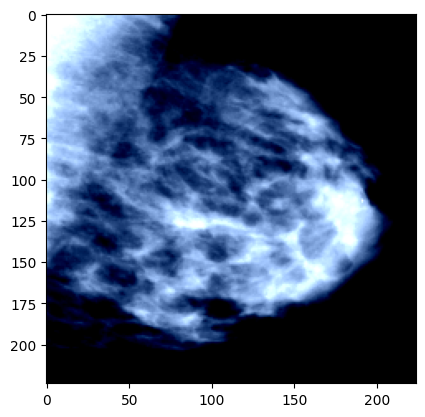

Label: 0


In [ ]:
# Test DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")